<a href="https://colab.research.google.com/github/shahdHesham13/Energy-Consumption-Analysis/blob/main/finalProjectNote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import needed libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration and Analysis

- Data Cleaning and Preparation
- Exploratory Analysis
- Feature Engineering
- Data Insights

will merge Sites Energy Consumption 3 parts sheets

In [ ]:
data_folder = "/content/drive/MyDrive/carerhaPractice/Data/Final Project"
file_paths = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.csv')]
dataframes = [pd.read_csv(file) for file in file_paths]
merged_data = pd.concat(dataframes, ignore_index=True)
print(f"Total rows: {len(merged_data)}")

Total rows: 1380252


In [ ]:
merged_data.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,"00:00:00 13,01,01",0.219,A,A
1,MAC000002,"00:30:00 13,01,01",0.241,A,A
2,MAC000002,"01:00:00 13,01,01",0.191,A,A
3,MAC000002,"01:30:00 13,01,01",0.235,A,A
4,MAC000002,"02:00:00 13,01,01",0.182,A,A


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 5 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   cell_id                  1380252 non-null  object 
 1   DateTime                 1380252 non-null  object 
 2   KWH/hh (per half hour)   1380252 non-null  float64
 3   site_id                  1380252 non-null  object 
 4   region                   1380252 non-null  object 
dtypes: float64(1), object(4)
memory usage: 52.7+ MB


as noticed `DateTime` column type is object which is incorrect and also will limit what can be done with the date information espically in this level of granuality

so will transform that and parse the `DateTime` column into separate features on different levels like Hour, Day, Week, and Month.

In [ ]:
# split the column into Time and Date
merged_data[['Time', 'Date']] = merged_data['DateTime'].str.split(' ', expand=True)

# set the date format (YYYY-MM-DD)
merged_data['Date'] = merged_data['Date'].apply(lambda x: '20' + x.replace(',', '-'))
merged_data['DateTime'] = pd.to_datetime(merged_data['Date'] + ' ' + merged_data['Time'], errors='coerce')

# drop nulls
merged_data = merged_data.dropna(subset=['DateTime'])

##
get other levels of granuality can be valuable in getting insights about trends

In [ ]:
merged_data['Hour'] = merged_data['DateTime'].dt.hour
merged_data['Day'] = merged_data['DateTime'].dt.day
merged_data['Week'] = merged_data['DateTime'].dt.isocalendar().week
merged_data['Month'] = merged_data['DateTime'].dt.month

In [ ]:
merged_data.isna().sum()

,0
cell_id,0
DateTime,0
KWH/hh (per half hour),0
site_id,0
region,0
Time,0
Date,0
Hour,0
Day,0
Week,0


so no null valuse

In [ ]:
merged_data[merged_data.duplicated()]

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Time,Date,Hour,Day,Week,Month


no duplicated values

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 545451 entries, 0 to 1380251
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   cell_id                  545451 non-null  object        
 1   DateTime                 545451 non-null  datetime64[ns]
 2   KWH/hh (per half hour)   545451 non-null  float64       
 3   site_id                  545451 non-null  object        
 4   region                   545451 non-null  object        
 5   Time                     545451 non-null  object        
 6   Date                     545451 non-null  object        
 7   Hour                     545451 non-null  int32         
 8   Day                      545451 non-null  int32         
 9   Week                     545451 non-null  UInt32        
 10  Month                    545451 non-null  int32         
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(3), object(5)
memory usage: 42.

Will now move to the anomalies exploring and undertanding the nature of data

In [ ]:
merged_data.describe()

,DateTime,KWH/hh (per half hour),Hour,Day,Week,Month
count,545451,545451.000000,545451.000000,545451.000000,545451.0,545451.000000
mean,2013-06-22 07:32:46.654383616,0.238625,11.499733,6.407173,25.266537,6.497295
min,2013-01-01 00:00:00,0.000000,0.000000,1.000000,1.0,1.000000
25%,2013-03-12 23:00:00,0.065000,5.000000,3.000000,11.0,3.000000
50%,2013-06-12 22:00:00,0.136000,11.000000,6.000000,24.0,6.000000
75%,2013-09-12 23:00:00,0.265000,18.000000,9.000000,37.0,9.000000
max,2013-12-12 23:30:00,999.000000,23.000000,12.000000,50.0,12.000000
std,NaN,2.241031,6.922420,3.442934,15.018398,3.452157


for `DateTime` min and max values the minimum Date Time is `2013-01-01 00:00:00` and the maximum is `2013-12-12 23:30:00` This tells that this dataset spans a year

#### Hanldling missing values

In [ ]:
unique_intervals = merged_data['DateTime'].nunique()
print(f"Number of unique DateTime intervals: {unique_intervals}")

Number of unique DateTime intervals: 6912


In [ ]:
merged_data[merged_data['DateTime'] == '2013-01-13 00:00:00']

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Time,Date,Hour,Day,Week,Month


Notice there is some intervals of time are missing not recorded

In [ ]:
min_date = merged_data['DateTime'].min()
max_date = merged_data['DateTime'].max()

# create a range of the DateTime every half hour interval
full_date_range = pd.date_range(min_date, max_date, freq='30T')

# Iterate through regions to find missing DateTime values for each region
missing_dates_by_region = {}
for region in merged_data['region'].unique():
    # the current region
    region_data = merged_data[merged_data['region'] == region]

    # get the DateTime values in this region
    region_date_range = region_data['DateTime'].sort_values().unique()

    # compare the full range of interval with the region exsisting DateTime values to get the missings
    missing_dates = set(full_date_range) - set(region_date_range)
    missing_dates_by_region[region] = missing_dates

for region, missing_dates in missing_dates_by_region.items():
    print(f"Missing DateTimes for region {region}:")
    print(sorted(missing_dates))
    print("\n")

<ipython-input-15-3d574ba8b96c>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_date_range = pd.date_range(min_date, max_date, freq='30T')


Missing DateTimes for region A:
[Timestamp('2013-01-13 00:00:00'), Timestamp('2013-01-13 00:30:00'), Timestamp('2013-01-13 01:00:00'), Timestamp('2013-01-13 01:30:00'), Timestamp('2013-01-13 02:00:00'), Timestamp('2013-01-13 02:30:00'), Timestamp('2013-01-13 03:00:00'), Timestamp('2013-01-13 03:30:00'), Timestamp('2013-01-13 04:00:00'), Timestamp('2013-01-13 04:30:00'), Timestamp('2013-01-13 05:00:00'), Timestamp('2013-01-13 05:30:00'), Timestamp('2013-01-13 06:00:00'), Timestamp('2013-01-13 06:30:00'), Timestamp('2013-01-13 07:00:00'), Timestamp('2013-01-13 07:30:00'), Timestamp('2013-01-13 08:00:00'), Timestamp('2013-01-13 08:30:00'), Timestamp('2013-01-13 09:00:00'), Timestamp('2013-01-13 09:30:00'), Timestamp('2013-01-13 10:00:00'), Timestamp('2013-01-13 10:30:00'), Timestamp('2013-01-13 11:00:00'), Timestamp('2013-01-13 11:30:00'), Timestamp('2013-01-13 12:00:00'), Timestamp('2013-01-13 12:30:00'), Timestamp('2013-01-13 13:00:00'), Timestamp('2013-01-13 13:30:00'), Timestamp('2013

to handle these we should fill those missing records ,so I am considering two ways either to fill with a specific value (mean, median, or a placeholder value), or forward or backward filling which use the next or previous valid value to fill the missing and useful when data is sequential.

BUT using spicifice value specially the median I think will be better to keep the overall trend or feature of each region

In [ ]:
merged_data.groupby('region')['KWH/hh (per half hour) '].median().reset_index()

,region,KWH/hh (per half hour)
0,A,0.145
1,B,0.116
2,C,0.152
3,D,0.102


We have to make sure the data is clean so the median make sense to the real information of data

In [ ]:
merged_data.describe()

,DateTime,KWH/hh (per half hour),Hour,Day,Week,Month
count,545451,545451.000000,545451.000000,545451.000000,545451.0,545451.000000
mean,2013-06-22 07:32:46.654383616,0.238625,11.499733,6.407173,25.266537,6.497295
min,2013-01-01 00:00:00,0.000000,0.000000,1.000000,1.0,1.000000
25%,2013-03-12 23:00:00,0.065000,5.000000,3.000000,11.0,3.000000
50%,2013-06-12 22:00:00,0.136000,11.000000,6.000000,24.0,6.000000
75%,2013-09-12 23:00:00,0.265000,18.000000,9.000000,37.0,9.000000
max,2013-12-12 23:30:00,999.000000,23.000000,12.000000,50.0,12.000000
std,NaN,2.241031,6.922420,3.442934,15.018398,3.452157


`KWH/hh (per half hour)` the Maximum value is 999 which seems weirdly high compared to the average of 0.238625. This could be an anomaly or an outlier false data or extremely high energy consumption at certain time so need to be checked further

the std 2.241031 indicates high variability in the data saying that the energy consumption can vary greatly between intervals

so, the median is a better representation to use of typical consumption than the mean which is skewed by the outliers

but first will Investigate outliers for `KWH/hh (per half hour)` to decide if it is real part of the data or anomality

there is significant variation in daily consumption, which may be caused by factors such as seasonal differences, population consumption habits, or specific events

In [ ]:
# Calculate IQR (Interquartile Range)
q1 = merged_data['KWH/hh (per half hour) '].quantile(0.25)
q3 = merged_data['KWH/hh (per half hour) '].quantile(0.75)
iqr = q3 - q1
iqr

0.2

the most of the values are tightly clustered

In [ ]:
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [ ]:
outliers = merged_data[(merged_data['KWH/hh (per half hour) '] < lower_bound) |
                       (merged_data['KWH/hh (per half hour) '] > upper_bound)]

print(f"Number of outliers: {outliers.shape[0]}")
print(f"Outlier bounds: [{lower_bound}, {upper_bound}]")

Number of outliers: 47333
Outlier bounds: [-0.23500000000000004, 0.5650000000000001]


47333 outliers values outside [-0.235, 0.565] were detected, there is too many to drop so will replace them

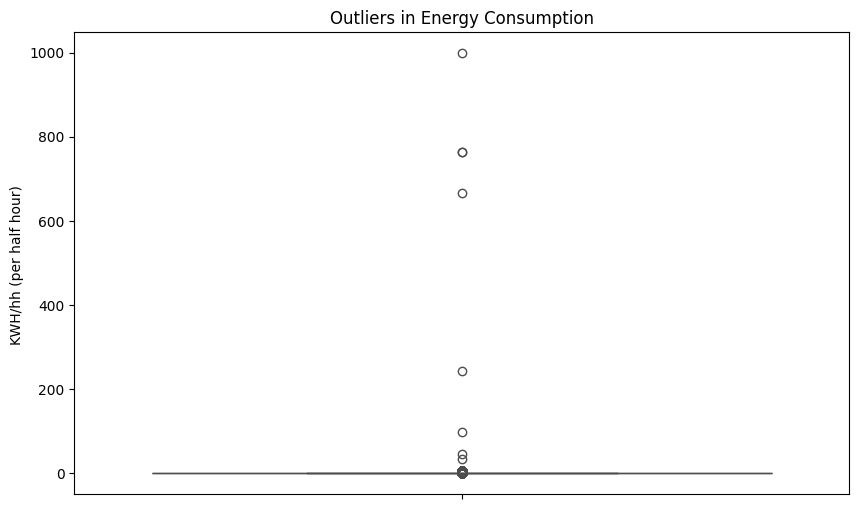

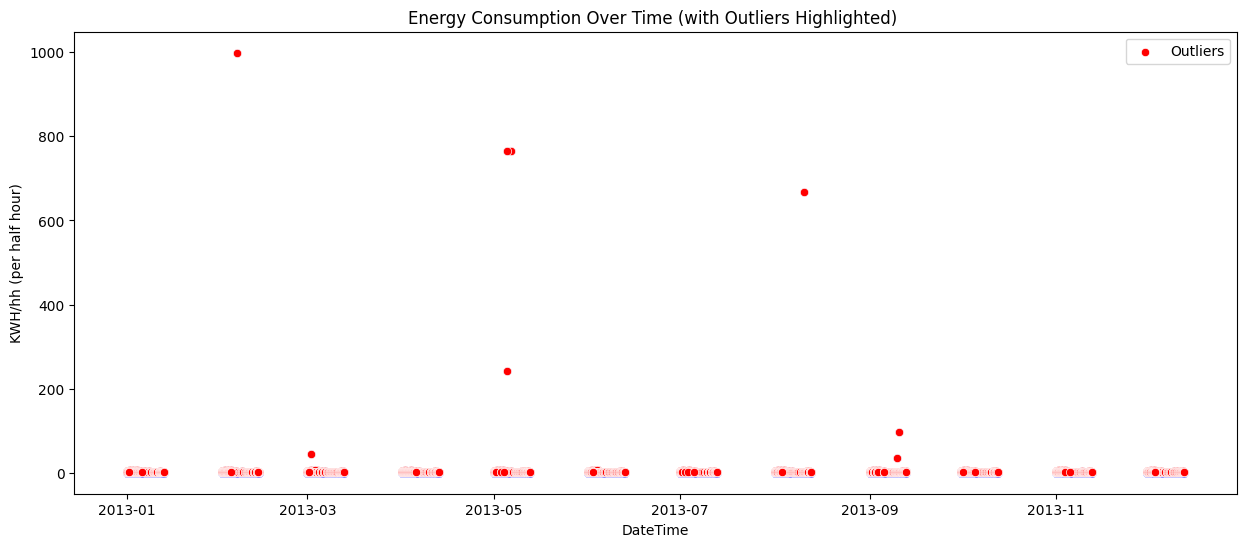

In [ ]:
# Box Plot outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, y='KWH/hh (per half hour) ', color='red')
plt.title('Outliers in Energy Consumption')
plt.ylabel('KWH/hh (per half hour) ')
plt.show()

# Scatter Plot for trends of outliers
plt.figure(figsize=(15, 6))
sns.scatterplot(data=merged_data, x='DateTime', y='KWH/hh (per half hour) ', alpha=0.3, color='blue')
sns.scatterplot(data=outliers, x='DateTime', y='KWH/hh (per half hour) ', color='red', label='Outliers')
plt.title('Energy Consumption Over Time (with Outliers Highlighted) ')
plt.xlabel('DateTime')
plt.ylabel('KWH/hh (per half hour)')
plt.legend()
plt.show()

As we see in the charts the presence of these outliers made it difficult to interpret the overall energy consumption trends and detect meaningful patterns in the data, they are skewing the data to a wide range

I do not think all the values of extreme events should be an error or worng unreal data and some can still be logical event that can happen infrequently

Replacing with the median of the column

In [ ]:
median_value = merged_data['KWH/hh (per half hour) '].median()
merged_data['KWH/hh (per half hour) '] = np.where(
    (merged_data['KWH/hh (per half hour) '] < lower_bound) |
    (merged_data['KWH/hh (per half hour) '] > upper_bound),
    median_value,
    merged_data['KWH/hh (per half hour) ']
)

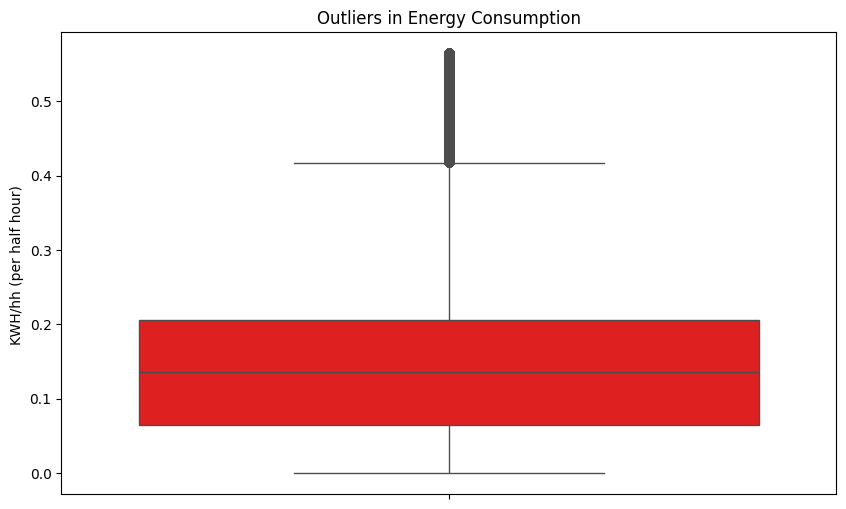

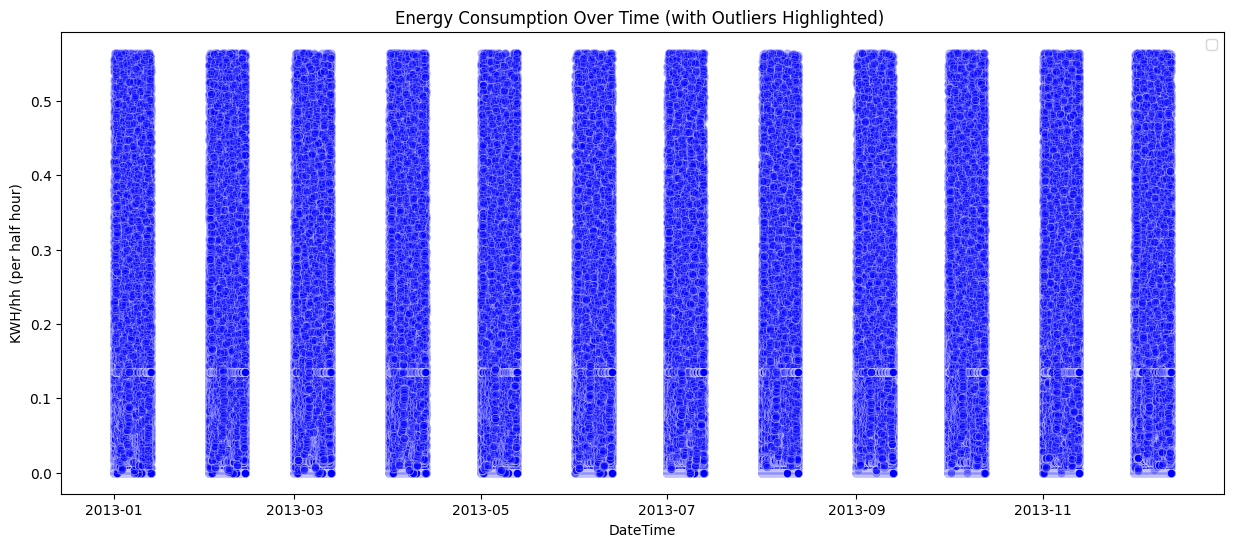

In [ ]:
# Box Plot outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, y='KWH/hh (per half hour) ', color='red')
plt.title('Outliers in Energy Consumption')
plt.ylabel('KWH/hh (per half hour) ')
plt.show()

# Scatter Plot for trends of outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = merged_data[(merged_data['KWH/hh (per half hour) '] < lower_bound) |
                       (merged_data['KWH/hh (per half hour) '] > upper_bound)]

plt.figure(figsize=(15, 6))
sns.scatterplot(data=merged_data, x='DateTime', y='KWH/hh (per half hour) ', alpha=0.3, color='blue')
sns.scatterplot(data=outliers, x='DateTime', y='KWH/hh (per half hour) ', color='red', label='Outliers')
plt.title('Energy Consumption Over Time (with Outliers Highlighted) ')
plt.xlabel('DateTime')
plt.ylabel('KWH/hh (per half hour)')
plt.legend()
plt.show()

Now after applying the Interquartile Range (IQR) method and replacing these extreme outliers with the median, the dataset became more representative of the general population

The distribution is now clearer with less distortion so this adjustment will allow to better see and understand the normal energy consumption behavior.


In [ ]:
merged_data.describe()

,DateTime,KWH/hh (per half hour),Hour,Day,Week,Month
count,545451,545451.000000,545451.000000,545451.000000,545451.0,545451.000000
mean,2013-06-22 07:32:46.654383616,0.154534,11.499733,6.407173,25.266537,6.497295
min,2013-01-01 00:00:00,0.000000,0.000000,1.000000,1.0,1.000000
25%,2013-03-12 23:00:00,0.065000,5.000000,3.000000,11.0,3.000000
50%,2013-06-12 22:00:00,0.136000,11.000000,6.000000,24.0,6.000000
75%,2013-09-12 23:00:00,0.206000,18.000000,9.000000,37.0,9.000000
max,2013-12-12 23:30:00,0.565000,23.000000,12.000000,50.0,12.000000
std,NaN,0.121409,6.922420,3.442934,15.018398,3.452157


so after replacing the outliers with the median what changed?

The mean has decreased from `0.2386` to `0.1545` which means it is now closer to the central tendency of the data and before was being skewing towards higher value

The standard deviation has decreased a lot from `2.2410` to `0.1214` which means now the data distribution is less spread out making the data easier to analyze and visualize

Overall the data now more centralized and more normal not influenced by extreme values

In [ ]:
merged_data.head(3)

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Time,Date,Hour,Day,Week,Month
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,00:00:00,2013-01-01,0,1,1,1
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,00:30:00,2013-01-01,0,1,1,1
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,01:00:00,2013-01-01,1,1,1,1


In [ ]:
merged_data['region'].unique()

array(['A', 'B', 'C', 'D'], dtype=object)

In [ ]:
merged_data['site_id'].unique()

array(['A', 'P', 'E', 'Q', 'H', 'L', 'N', 'K', 'J', 'U', 'D', 'G', 'C',
       'F'], dtype=object)

In [ ]:
merged_data['cell_id'].unique()

array(['MAC000002', 'MAC000003', 'MAC000004', 'MAC000006', 'MAC000007',
       'MAC000008', 'MAC000009', 'MAC000010', 'MAC000011', 'MAC000012',
       'MAC000013', 'MAC000016', 'MAC000018', 'MAC000019', 'MAC000020',
       'MAC000021', 'MAC000022', 'MAC000023', 'MAC000024', 'MAC000025',
       'MAC000026', 'MAC000027', 'MAC000028', 'MAC000029', 'MAC000030',
       'MAC000032', 'MAC000033', 'MAC000034', 'MAC000035', 'MAC000069',
       'MAC000070', 'MAC000072', 'MAC000073', 'MAC000074', 'MAC000077',
       'MAC000078', 'MAC000079', 'MAC000080', 'MAC000081', 'MAC000083',
       'MAC000084', 'MAC000085', 'MAC000086', 'MAC000087', 'MAC000089',
       'MAC000090', 'MAC000091', 'MAC000092', 'MAC000093', 'MAC000094',
       'MAC000095', 'MAC000096', 'MAC000097', 'MAC000098', 'MAC000099',
       'MAC000100', 'MAC000036', 'MAC000037', 'MAC000038', 'MAC000039',
       'MAC000040', 'MAC000041', 'MAC000042', 'MAC000043', 'MAC000045',
       'MAC000047', 'MAC000049', 'MAC000050', 'MAC000053', 'MAC0

the values are unique with no typo or two values same meaning


<br>
Back to handleling the missing records will generate its energy consumption values with the median in each region as the median more accurate here to keep the same information about that region

In [ ]:
# the new row for missings
new_rows = []
for region, missing_dates in missing_dates_by_region.items():
    region_data = merged_data[merged_data['region'] == region]

    # the value of median of each region which to fill with
    median_kwh = region_data['KWH/hh (per half hour) '].median()

    # generating the new rows
    for missing_date in missing_dates:
        new_row = {
            'DateTime': missing_date,
            'cell_id': region_data['cell_id'].iloc[0],
            'KWH/hh (per half hour) ': median_kwh,
            'site_id': region_data['site_id'].iloc[0],
            'region': region,
            'Time': missing_date.time(),
            'Date': missing_date.date(),
            'Hour': missing_date.hour,
            'Day': missing_date.day,
            'Week': missing_date.isocalendar()[1],
            'Month': missing_date.month
        }
        new_rows.append(new_row)
new_rows_df = pd.DataFrame(new_rows)

merged_data = pd.concat([merged_data, new_rows_df], ignore_index=True)
merged_data = merged_data.sort_values(by='DateTime').reset_index(drop=True)

merged_data.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Time,Date,Hour,Day,Week,Month
0,MAC000002,2013-01-01,0.219,A,A,00:00:00,2013-01-01,0,1,1,1
1,MAC000021,2013-01-01,0.372,E,A,00:00:00,2013-01-01,0,1,1,1
2,MAC000019,2013-01-01,0.195,K,B,00:00:00,2013-01-01,0,1,1,1
3,MAC000034,2013-01-01,0.136,E,A,00:00:00,2013-01-01,0,1,1,1
4,MAC000007,2013-01-01,0.247,H,C,00:00:00,2013-01-01,0,1,1,1


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584235 entries, 0 to 584234
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   cell_id                  584235 non-null  object        
 1   DateTime                 584235 non-null  datetime64[ns]
 2   KWH/hh (per half hour)   584235 non-null  float64       
 3   site_id                  584235 non-null  object        
 4   region                   584235 non-null  object        
 5   Time                     584235 non-null  object        
 6   Date                     584235 non-null  object        
 7   Hour                     584235 non-null  int64         
 8   Day                      584235 non-null  int64         
 9   Week                     584235 non-null  Int64         
 10  Month                    584235 non-null  int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 

column `Date` is object should convert it

In [ ]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

In [ ]:
merged_data.describe()

,DateTime,KWH/hh (per half hour),Date,Hour,Day,Week,Month
count,584235,584235.000000,584235,584235.000000,584235.000000,584235.0,584235.000000
mean,2013-06-22 09:11:23.441423616,0.152407,2013-06-21 21:26:24.354925312,11.499751,7.422573,25.275791,6.466254
min,2013-01-01 00:00:00,0.000000,2013-01-01 00:00:00,0.000000,1.000000,1.0,1.000000
25%,2013-03-27 19:00:00,0.069000,2013-03-27 00:00:00,5.000000,4.000000,13.0,3.000000
50%,2013-06-21 16:30:00,0.136000,2013-06-21 00:00:00,11.000000,7.000000,25.0,6.000000
75%,2013-09-16 22:45:00,0.196000,2013-09-16 00:00:00,18.000000,10.000000,38.0,9.000000
max,2013-12-12 23:30:00,0.565000,2013-12-12 00:00:00,23.000000,31.000000,50.0,12.000000
std,NaN,0.117640,NaN,6.922405,5.239435,14.935464,3.434871



#### Total Energy Consumption by cell

<ipython-input-33-28011d7a4666>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x='cell_id', y='KWH/hh (per half hour) ', palette='viridis')


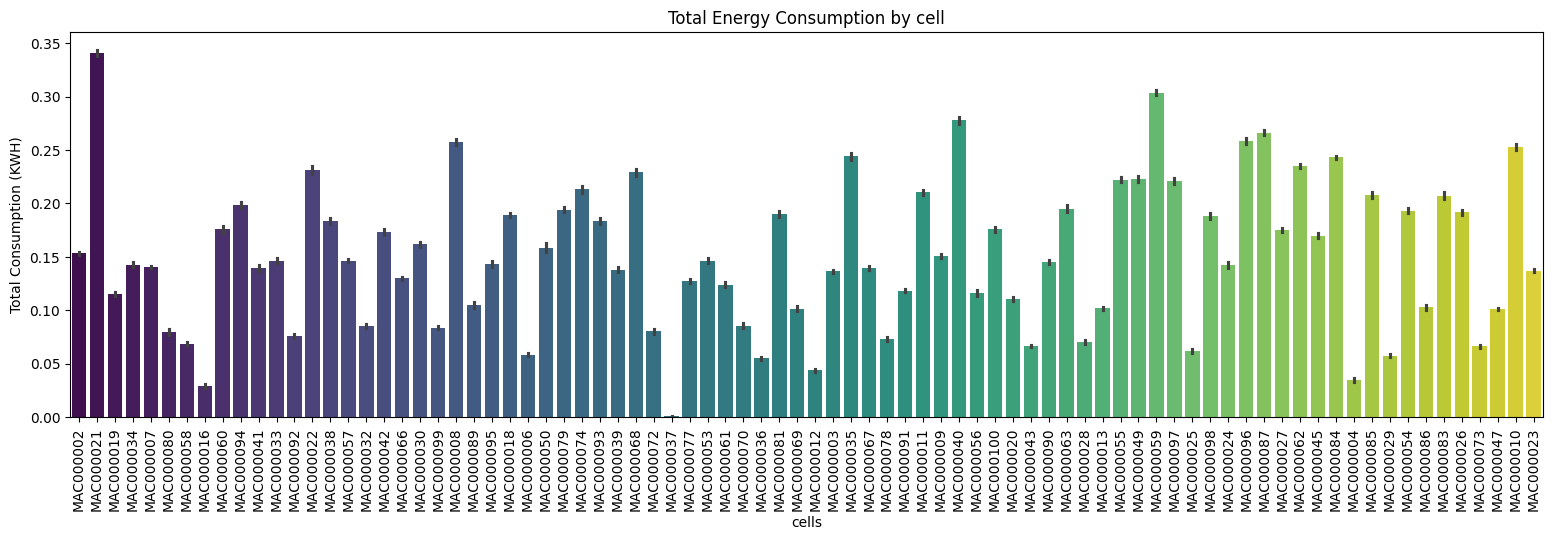

In [ ]:
plt.figure(figsize=(19, 5))
sns.barplot(data=merged_data, x='cell_id', y='KWH/hh (per half hour) ', palette='viridis')
plt.title('Total Energy Consumption by cell')
plt.xlabel('cells')
plt.ylabel('Total Consumption (KWH)')
plt.xticks(rotation=90)
plt.show()

notice a cell values are all Zero, there is variability in usage across cells, few cells consume much more energy compared to others

In [ ]:
zeroValueCell = merged_data[merged_data['KWH/hh (per half hour) '] == 0]

# get the unique 'cell_id' values where the energy is zero
zeroValueCell = zeroValueCell['cell_id'].unique()
zeroValueCell

array(['MAC000006', 'MAC000037', 'MAC000012', 'MAC000056', 'MAC000004',
       'MAC000036', 'MAC000092', 'MAC000070', 'MAC000032', 'MAC000029',
       'MAC000061', 'MAC000025', 'MAC000041', 'MAC000028'], dtype=object)

I think logically even if a cell its all values all the time is Zero still makes sense


#### Energy Consumption Over Time

Is there seasonal variations in the daily energy use?

In [ ]:
merged_data['Day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

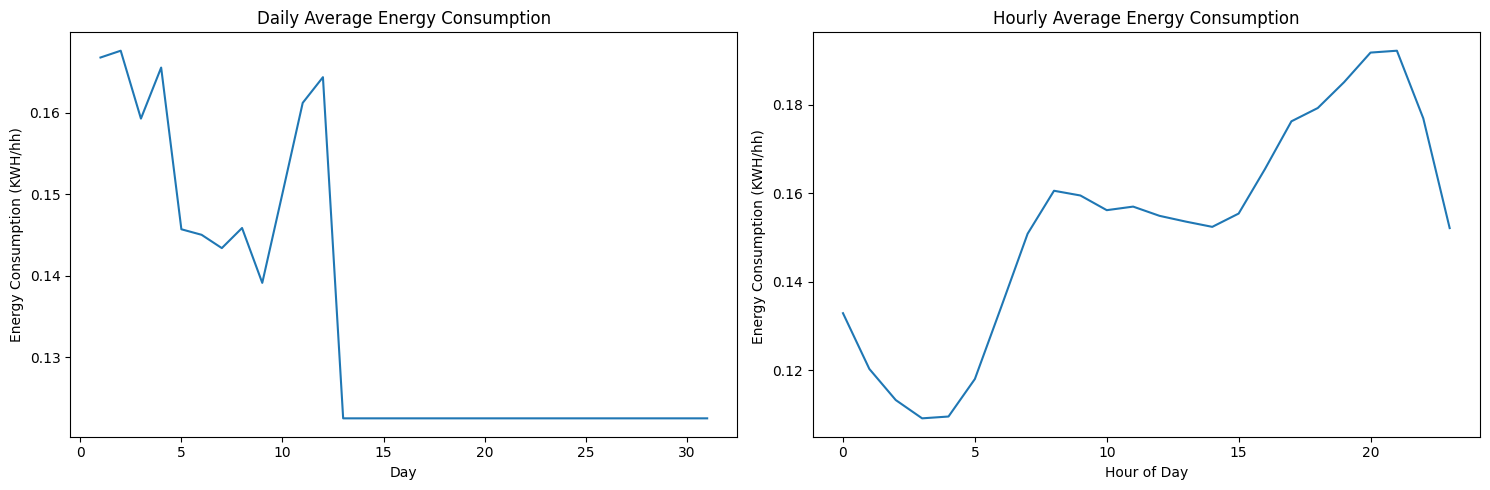

In [ ]:
# daily and hourly consumption
daily_avg = merged_data.groupby('Day')['KWH/hh (per half hour) '].mean().reset_index()
daily_avg = daily_avg[daily_avg['Day'].between(1, 31)]
hourly_avg = merged_data.groupby('Hour')['KWH/hh (per half hour) '].mean().reset_index()


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=daily_avg, x='Day', y='KWH/hh (per half hour) ', ax=axes[0])
axes[0].set_title('Daily Average Energy Consumption')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Energy Consumption (KWH/hh)')

sns.lineplot(data=hourly_avg, x='Hour', y='KWH/hh (per half hour) ', ax=axes[1])
axes[1].set_title('Hourly Average Energy Consumption')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Energy Consumption (KWH/hh) ')

plt.tight_layout()
plt.show()

Seems to be sharp drop in energy consumption to zero for the last half of the month maybe there was no data recorded for those days or missing data or could be an operational shutdown

In [ ]:
daily_avg['Day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
daily_avg['Day'].isna().sum()

0

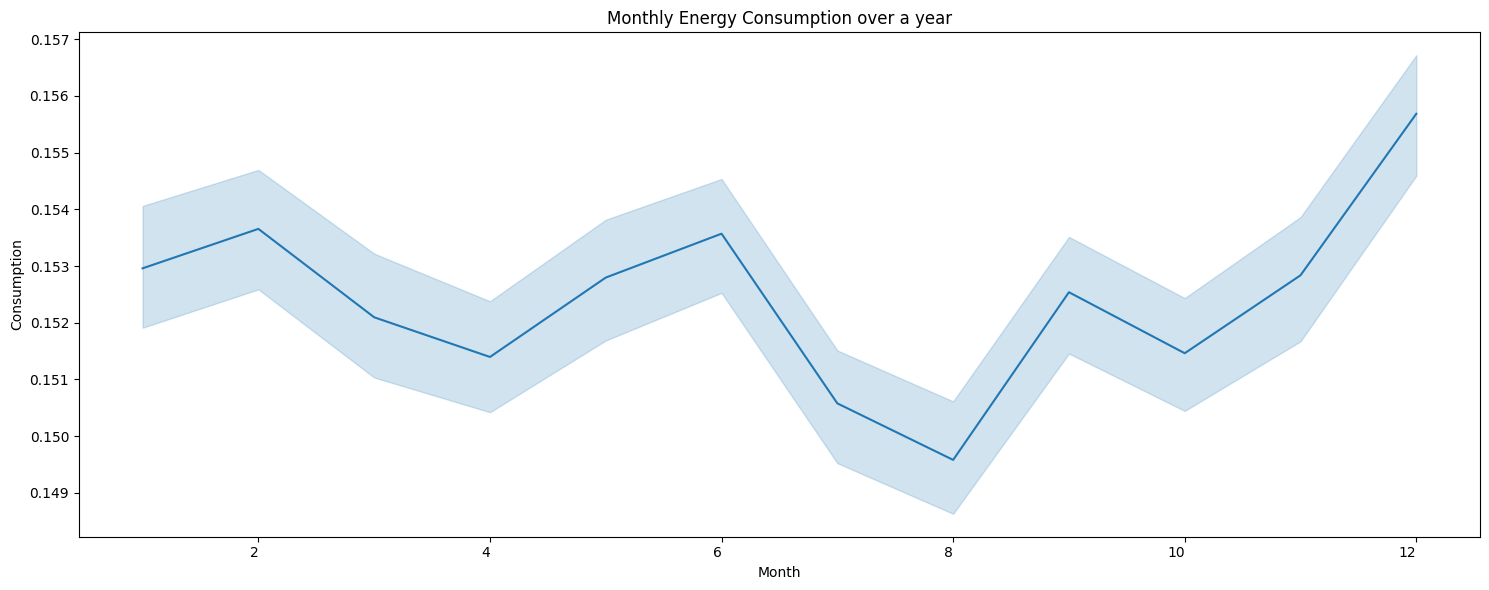

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Month', y='KWH/hh (per half hour) ', data=merged_data)
plt.xlabel('Month')
plt.ylabel('Consumption')
plt.title('Monthly Energy Consumption over a year')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

Higher consumption observed in specific months, likely due to seasonal demand

#### Energy Consumption across Time of Day

Adding more feature for the time of day

<ipython-input-40-7a617562a944>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=time_of_day_consumption, x='Time_of_Day', y='Total_Consumption', palette='viridis')


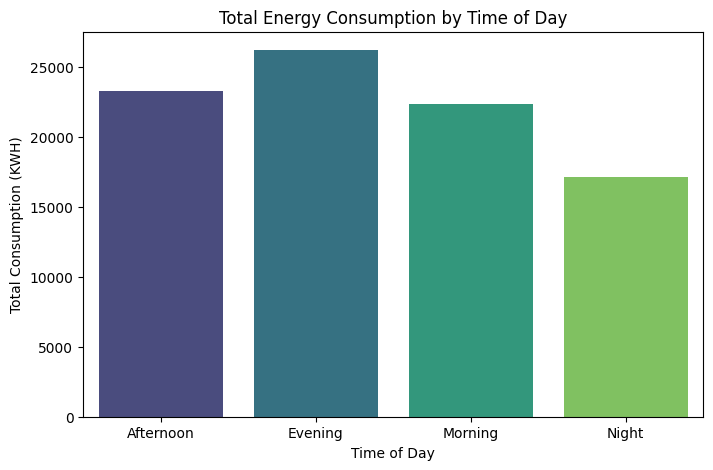

In [ ]:
# which time of day
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

merged_data['Time_of_Day'] = merged_data['Hour'].apply(time_of_day)

time_of_day_consumption = merged_data.groupby('Time_of_Day')['KWH/hh (per half hour) '].sum().reset_index()
time_of_day_consumption.rename(columns={'KWH/hh (per half hour) ': 'Total_Consumption'}, inplace=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=time_of_day_consumption, x='Time_of_Day', y='Total_Consumption', palette='viridis')
plt.title('Total Energy Consumption by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Total Consumption (KWH)')
plt.show()


Peak usage observed during specific hours in evening and dips during night hours this information of high-demand hours are can be helpful for energy optimization strategies

<ipython-input-41-e03633aa520a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Time_of_Day', y='KWH/hh (per half hour) ', data=data, palette='Set2')


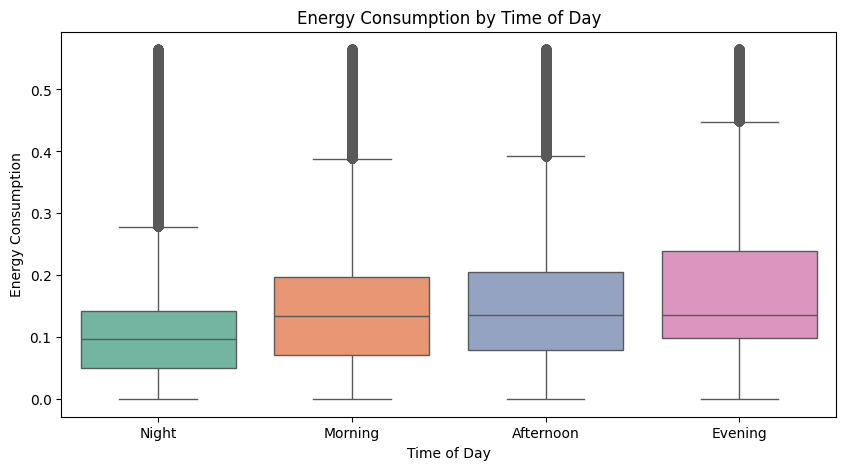

In [ ]:
def plot_time_of_day(data):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Time_of_Day', y='KWH/hh (per half hour) ', data=data, palette='Set2')
    plt.title('Energy Consumption by Time of Day')
    plt.xlabel('Time of Day')
    plt.ylabel('Energy Consumption')
    plt.show()
plot_time_of_day(merged_data)

#### Energy Consumption differences between weekdays and weekends.

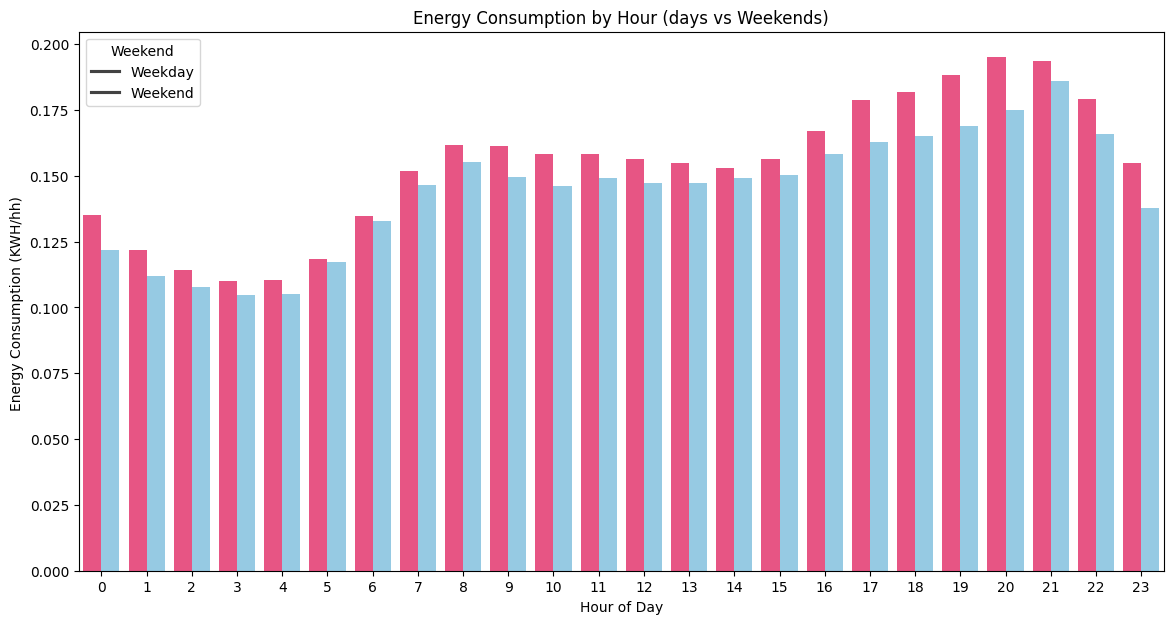

In [ ]:
# Add a new feature is weekend/weekday
merged_data['is_weekend'] = merged_data['Day'].apply(lambda x: 1 if x in [6, 7] else 0)

time_of_day = merged_data.groupby(['Hour', 'is_weekend'])['KWH/hh (per half hour) '].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=time_of_day, x='Hour', y='KWH/hh (per half hour) ', hue='is_weekend', palette=['#FF3D7B', '#89cff0'])
plt.title('Energy Consumption by Hour (days vs Weekends)')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (KWH/hh) ')
plt.legend(title='Weekend', labels=['Weekday', 'Weekend'])
plt.show()

lower energy consumption on weekdays in which people may tend to follow a more routine schedule so the week days have more consistent operational activity thaan weekends and can be in organizations or regions that may implement energy-saving practices reducing the usage of equipments

and in the trend of many people work from home weekdays may show higher energy consumption due to longer hours spent at home

#### Energy Distribution for Region

How geography impacts energy use?

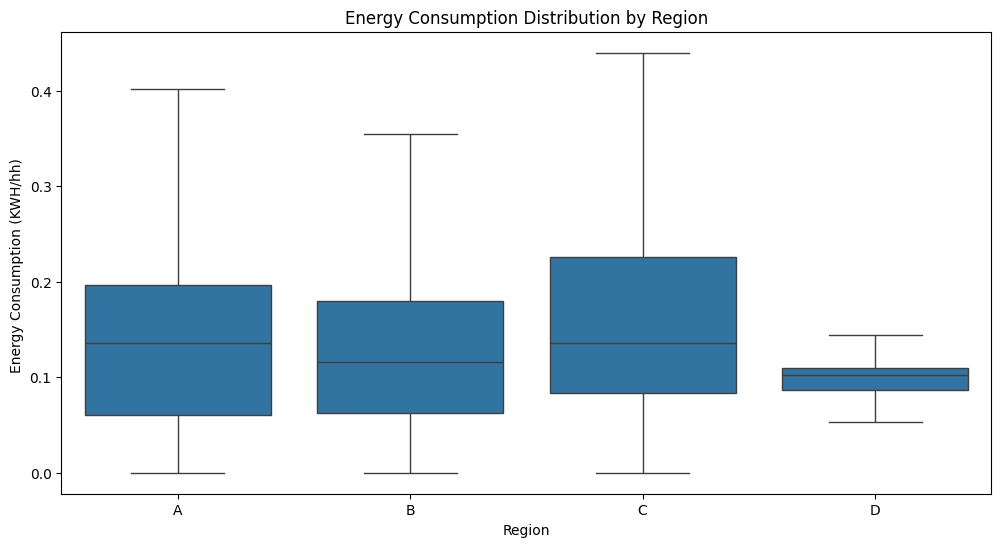

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='region', y='KWH/hh (per half hour) ', showfliers=False)
plt.title('Energy Consumption Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Energy Consumption (KWH/hh) ')
plt.show()

#### Each region have how many sites?

Regional differences in energy usage may reflect variations in population density.

<ipython-input-44-b91ffba89b0c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sites_per_region.index, y=sites_per_region.values, palette='viridis')


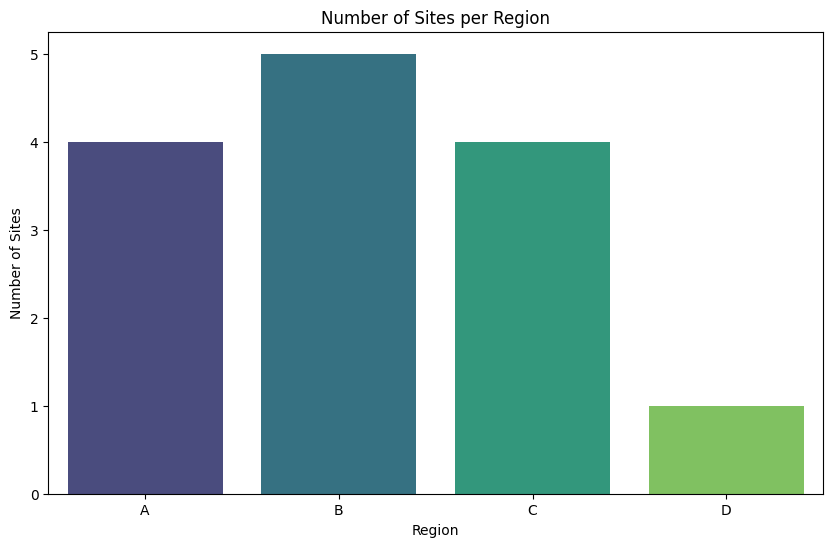

In [ ]:
sites_per_region = merged_data.groupby('region')['site_id'].nunique()

plt.figure(figsize=(10, 6))
sns.barplot(x=sites_per_region.index, y=sites_per_region.values, palette='viridis')
plt.title('Number of Sites per Region')
plt.xlabel('Region')
plt.ylabel('Number of Sites')
plt.show()

#### Energy Consumption by Sites

What the Highest & lowest energy-consuming sites?

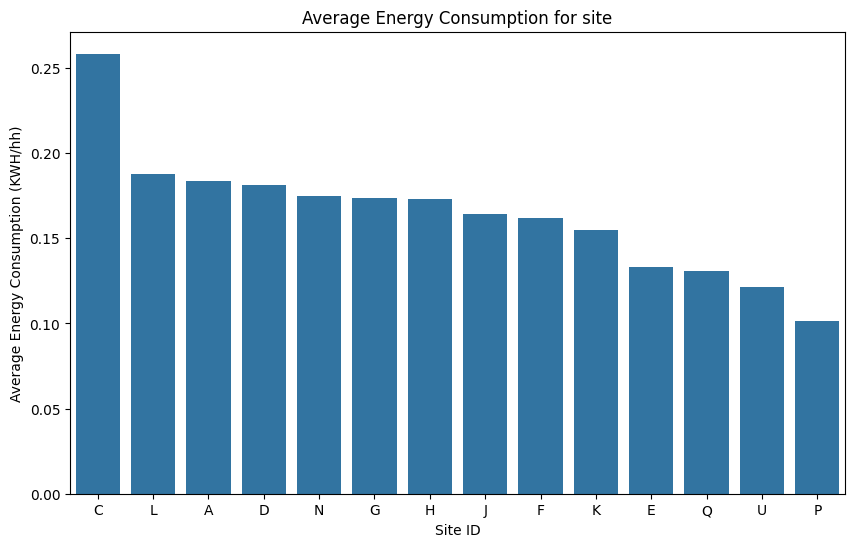

In [ ]:
site_avg = merged_data.groupby('site_id')['KWH/hh (per half hour) '].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=site_avg.index, y=site_avg.values)
plt.title('Average Energy Consumption for site')
plt.xlabel('Site ID')
plt.ylabel('Average Energy Consumption (KWH/hh)')
plt.show()

Site C with the higher consumption may require additional resources or prioritize optimization efforts


In [ ]:
# merged_data = merged_data.drop(columns=['Hour', 'Day', 'Week', 'Month', 'is_weekend', 'Date', 'Time'])

In [ ]:
file_name = '/content/drive/MyDrive/carerhaPractice/Data/Final Project/Demand.xlsx'
dataDemand = pd.read_excel(file_name)
dataDemand

,DemandDateTime,Demand
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal
...,...,...
17515,2013-12-31 21:30:00,Normal
17516,2013-12-31 22:00:00,Normal
17517,2013-12-31 22:30:00,Normal
17518,2013-12-31 23:00:00,Normal


In [ ]:
dataDemand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DemandDateTime  17520 non-null  datetime64[ns]
 1   Demand          17520 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 273.9+ KB


In [ ]:
dataDemand['Demand'].unique()

array(['Normal', 'Low', 'Normall', 'High', 'normal', 'high'], dtype=object)

there is only three unique values of the `Demand` type

In [ ]:
dataDemand['Demand'] = dataDemand['Demand'].str.lower()
correct_mapping = {
    'low': 'Low',
    'normal': 'Normal',
    'normall': 'Normal',
    'high': 'High'
}
dataDemand['Demand'] = dataDemand['Demand'].map(correct_mapping)
dataDemand = dataDemand[dataDemand['Demand'].isin(['Low', 'Normal', 'High'])]
dataDemand = dataDemand[['DemandDateTime', 'Demand']]

dataDemand['Demand'].unique()

array(['Normal', 'Low', 'High'], dtype=object)

In [ ]:
dataDemand['Demand'].value_counts()

,count
Demand,
Normal,15072
Low,1660
High,788


merging the two dataframes

In [ ]:
dataDemand.rename(columns={'DemandDateTime': 'DateTime'}, inplace=True)
data = pd.merge(merged_data, dataDemand, on='DateTime', how='left')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584235 entries, 0 to 584234
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   cell_id                  584235 non-null  object        
 1   DateTime                 584235 non-null  datetime64[ns]
 2   KWH/hh (per half hour)   584235 non-null  float64       
 3   site_id                  584235 non-null  object        
 4   region                   584235 non-null  object        
 5   Time                     584235 non-null  object        
 6   Date                     584235 non-null  datetime64[ns]
 7   Hour                     584235 non-null  int64         
 8   Day                      584235 non-null  int64         
 9   Week                     584235 non-null  Int64         
 10  Month                    584235 non-null  int64         
 11  Time_of_Day              584235 non-null  object        
 12  is_weekend      

no null values

In [ ]:
data.isna().sum()

,0
cell_id,0
DateTime,0
KWH/hh (per half hour),0
site_id,0
region,0
Time,0
Date,0
Hour,0
Day,0
Week,0


In [ ]:
data

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Time,Date,Hour,Day,Week,Month,Time_of_Day,is_weekend,Demand
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal
1,MAC000021,2013-01-01 00:00:00,0.372,E,A,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal
2,MAC000019,2013-01-01 00:00:00,0.195,K,B,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal
3,MAC000034,2013-01-01 00:00:00,0.136,E,A,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal
4,MAC000007,2013-01-01 00:00:00,0.247,H,C,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584230,MAC000083,2013-12-12 23:30:00,0.071,J,C,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low
584231,MAC000068,2013-12-12 23:30:00,0.136,L,B,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low
584232,MAC000027,2013-12-12 23:30:00,0.147,J,C,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low
584233,MAC000003,2013-12-12 23:30:00,0.147,P,B,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low


calculating the cost of energy consumption with each Demand prices

In [ ]:
def costRow(row):
    demandPrice = {
        'High': 77.21,
        'Normal': 19.46,
        'Low': 6.89
    }
    price = demandPrice.get(row['Demand'], 0)
    return row['KWH/hh (per half hour) '] * price / 100

data['Cost(EGP)'] = data.apply(costRow, axis=1)

In [ ]:
data

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Time,Date,Hour,Day,Week,Month,Time_of_Day,is_weekend,Demand,Cost(EGP)
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.042617
1,MAC000021,2013-01-01 00:00:00,0.372,E,A,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.072391
2,MAC000019,2013-01-01 00:00:00,0.195,K,B,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.037947
3,MAC000034,2013-01-01 00:00:00,0.136,E,A,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.026466
4,MAC000007,2013-01-01 00:00:00,0.247,H,C,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.048066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584230,MAC000083,2013-12-12 23:30:00,0.071,J,C,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low,0.004892
584231,MAC000068,2013-12-12 23:30:00,0.136,L,B,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low,0.009370
584232,MAC000027,2013-12-12 23:30:00,0.147,J,C,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low,0.010128
584233,MAC000003,2013-12-12 23:30:00,0.147,P,B,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low,0.010128


In [ ]:
data['site_id'].unique()

array(['A', 'E', 'K', 'H', 'F', 'G', 'Q', 'L', 'U', 'D', 'P', 'N', 'J',
       'C'], dtype=object)

In [ ]:
data['cell_id'].unique()

array(['MAC000002', 'MAC000021', 'MAC000019', 'MAC000034', 'MAC000007',
       'MAC000080', 'MAC000058', 'MAC000016', 'MAC000060', 'MAC000094',
       'MAC000041', 'MAC000033', 'MAC000092', 'MAC000022', 'MAC000038',
       'MAC000057', 'MAC000032', 'MAC000042', 'MAC000066', 'MAC000030',
       'MAC000099', 'MAC000008', 'MAC000089', 'MAC000095', 'MAC000018',
       'MAC000006', 'MAC000050', 'MAC000079', 'MAC000074', 'MAC000093',
       'MAC000039', 'MAC000068', 'MAC000072', 'MAC000037', 'MAC000077',
       'MAC000053', 'MAC000061', 'MAC000070', 'MAC000036', 'MAC000081',
       'MAC000069', 'MAC000012', 'MAC000003', 'MAC000035', 'MAC000067',
       'MAC000078', 'MAC000091', 'MAC000011', 'MAC000009', 'MAC000040',
       'MAC000056', 'MAC000100', 'MAC000020', 'MAC000043', 'MAC000090',
       'MAC000063', 'MAC000028', 'MAC000013', 'MAC000055', 'MAC000049',
       'MAC000059', 'MAC000097', 'MAC000025', 'MAC000098', 'MAC000024',
       'MAC000096', 'MAC000087', 'MAC000027', 'MAC000062', 'MAC0

In [ ]:
data.describe()

,DateTime,KWH/hh (per half hour),Date,Hour,Day,Week,Month,is_weekend,Cost(EGP)
count,584235,584235.000000,584235,584235.000000,584235.000000,584235.0,584235.000000,584235.000000,584235.000000
mean,2013-06-22 09:11:23.441423616,0.152407,2013-06-21 21:26:24.354925312,11.499751,7.422573,25.275791,6.466254,0.155336,0.031529
min,2013-01-01 00:00:00,0.000000,2013-01-01 00:00:00,0.000000,1.000000,1.0,1.000000,0.000000,0.000000
25%,2013-03-27 19:00:00,0.069000,2013-03-27 00:00:00,5.000000,4.000000,13.0,3.000000,0.000000,0.011871
50%,2013-06-21 16:30:00,0.136000,2013-06-21 00:00:00,11.000000,7.000000,25.0,6.000000,0.000000,0.025103
75%,2013-09-16 22:45:00,0.196000,2013-09-16 00:00:00,18.000000,10.000000,38.0,9.000000,0.000000,0.038531
max,2013-12-12 23:30:00,0.565000,2013-12-12 00:00:00,23.000000,31.000000,50.0,12.000000,1.000000,0.436236
std,NaN,0.117640,NaN,6.922405,5.239435,14.935464,3.434871,0.362225,0.033235


again there is positively skewness distribution in the data due to high outliers

`KWH/hh (per half hour)` std of '2.165548' & mean of '0.231331' saying there is significant variability in consumption

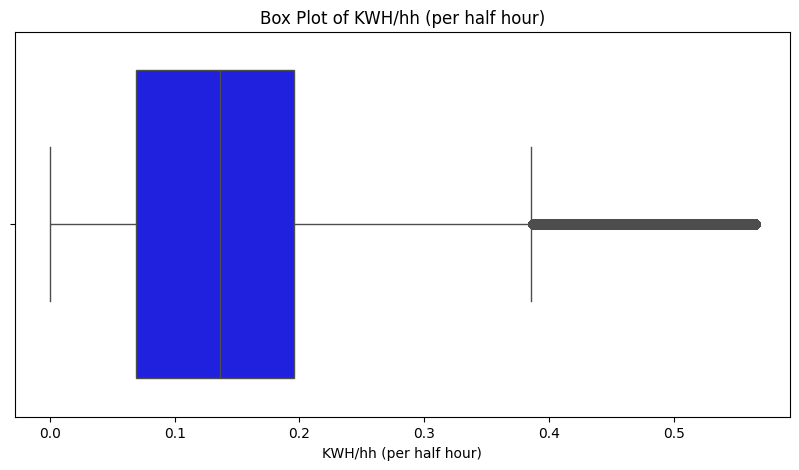

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='KWH/hh (per half hour) ', color='blue')
plt.title('Box Plot of KWH/hh (per half hour)')
plt.xlabel('KWH/hh (per half hour)')
plt.show()

How `Demand` categories (High, Normal, Low) vary in terms of energy consumption and cost?

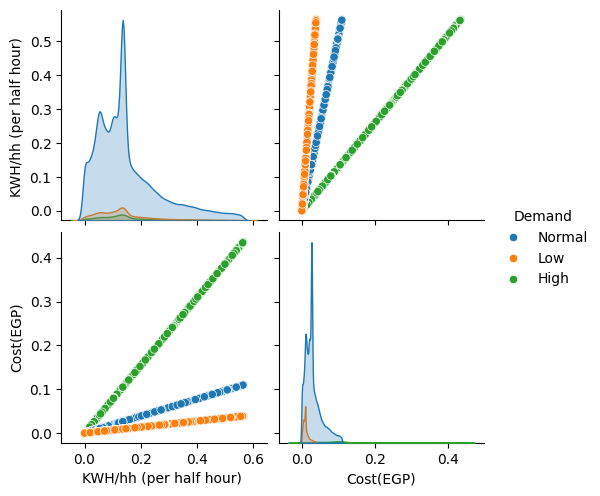

In [ ]:
selected_columns = data[['KWH/hh (per half hour) ', 'Cost(EGP)', 'Demand']]
sns.pairplot(selected_columns, hue='Demand')

the `demand` types for energy consumption but with the log scale of the cost to reduce the impact of extreme values

In [ ]:
#data['Cost_log'] = np.log1p(data['Cost(EGP)'])
#sns.pairplot(data[['KWH/hh (per half hour) ', 'Cost_log', 'Demand']], hue='Demand')

the distribution of `KWH/hh (per half hour)` across regions to highlight regional differences in energy usage patterns and identifies outliers within each region.

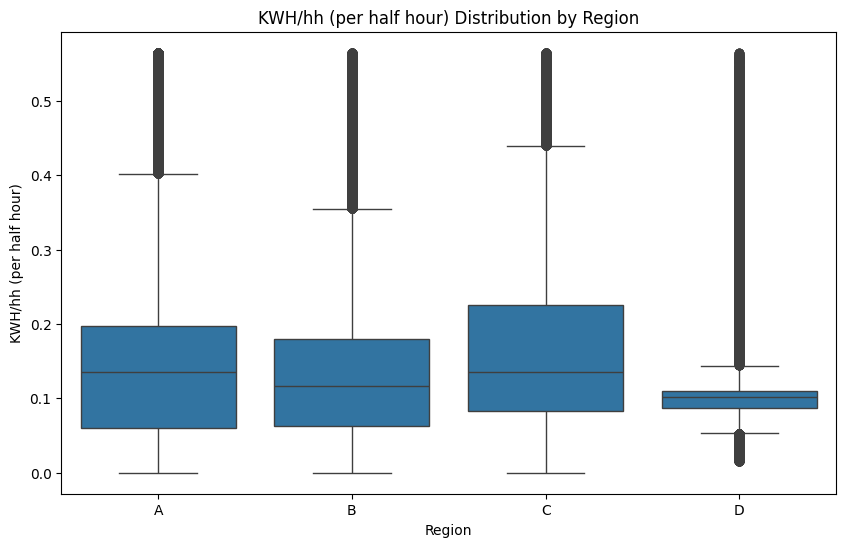

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='KWH/hh (per half hour) ', data=data)

plt.title('KWH/hh (per half hour) Distribution by Region')
plt.xlabel('Region')
plt.ylabel('KWH/hh (per half hour)')
plt.show()

KDE curves of the distribution of energy consumption across regions check if the data is approximately normal within each region

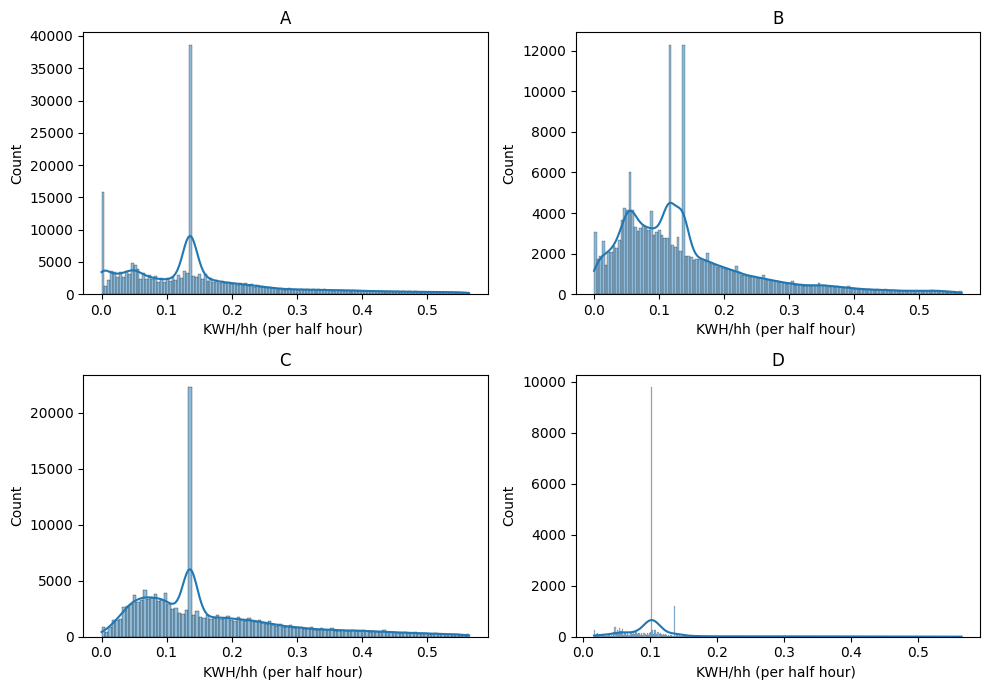

In [ ]:
# Create subplots
fig, axis = plt.subplots(2, 2, figsize=(10, 7))

# Plotting the distribution of 'KWH/hh (per half hour)' for each region
sns.histplot(data=data[data['region'] == 'A'], x='KWH/hh (per half hour) ', ax=axis[0, 0], kde=True)
axis[0, 0].set_title('A')

sns.histplot(data=data[data['region'] == 'B'], x='KWH/hh (per half hour) ', ax=axis[0, 1], kde=True)
axis[0, 1].set_title('B')

sns.histplot(data=data[data['region'] == 'C'], x='KWH/hh (per half hour) ', ax=axis[1, 0], kde=True)
axis[1, 0].set_title('C')

sns.histplot(data=data[data['region'] == 'D'], x='KWH/hh (per half hour) ', ax=axis[1, 1], kde=True)
axis[1, 1].set_title('D')

plt.tight_layout()
plt.show()

# Statistical Hypothesis Testing

 - Hypothesis Formulation
 - Test Selection and Application
 - Assumptions and Limitations

#### Does the region significantly affect energy consumption?

H₀: There is no significant difference in energy consumption across regions.<br>
H₁: There is a significant difference in energy consumption across regions.

so to check the mean energy consumption if it is the same for all regions or one/some is different will use ANOVA test for the categories

p-value < 0.05 : reject the null hypothesis<br>
p-value ≥ 0.05 : fail to reject the null hypothesis

In [ ]:
# Levene's Test for homogeneity of variances
stat, p_value = stats.levene(*[data[data['region'] == region]['KWH/hh (per half hour) '] for region in data['region'].unique()])
print(f"Levene's Test p-value: {p_value}")

Levene's Test p-value: 0.0


In [ ]:
# ANOVA Test
stat, p_value = stats.f_oneway(*[data[data['region'] == region]['KWH/hh (per half hour) '] for region in data['region'].unique()])
print(f"F-statistic: {stat}")
print(f"ANOVA Test p-value: {p_value}")

F-statistic: 2261.951759005499
ANOVA Test p-value: 0.0


There is greater variance in energy consumption between the different regions compared to within the region itself

There is a statistically difference in energy consumption across regions the `p-value` rejects the null hypothesis

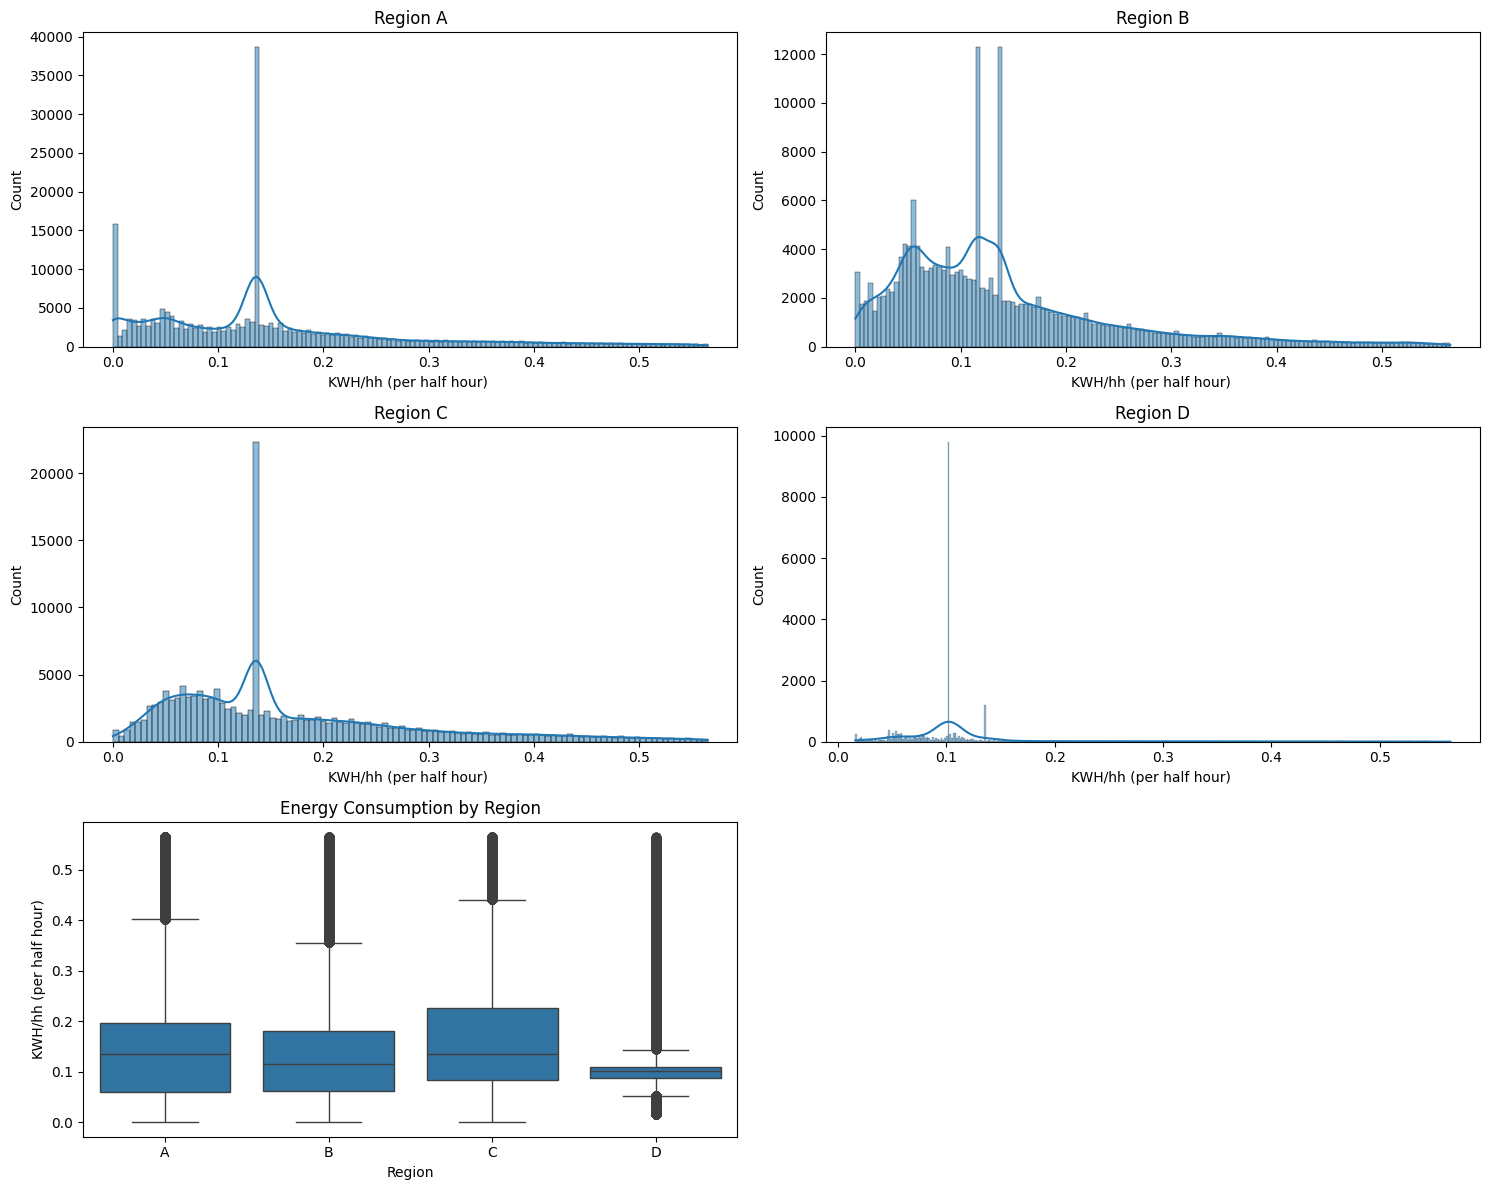

In [ ]:
def regionVis(data):
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    sns.histplot(data=data[data['region'] == 'A'], x='KWH/hh (per half hour) ', kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Region A')

    sns.histplot(data=data[data['region'] == 'B'], x='KWH/hh (per half hour) ', kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Region B')

    sns.histplot(data=data[data['region'] == 'C'], x='KWH/hh (per half hour) ', kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Region C')

    sns.histplot(data=data[data['region'] == 'D'], x='KWH/hh (per half hour) ', kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Region D')

    sns.boxplot(x='region', y='KWH/hh (per half hour) ', data=data, ax=axes[2, 0])
    axes[2, 0].set_title('Energy Consumption by Region')
    axes[2, 0].set_xlabel('Region')
    axes[2, 0].set_ylabel('KWH/hh (per half hour)')

    fig.delaxes(axes[2, 1])

    plt.tight_layout()
    plt.show()

regionVis(data)

#### Is there a relationship between the time of day and energy consumption?

H₀: There is no relationship between the time of day and energy consumption (KWH/hh).<br> H₁: There is a relationship between the time of day and energy consumption (KWH/hh).

the `Time_of_Day` is categorical and `energy` is continuous will use ANOVA test

In [ ]:
# ANOVA Test
stat, p_value = stats.f_oneway(*[data[data['Time_of_Day'] == Time_of_Day]['KWH/hh (per half hour) '] for Time_of_Day in data['Time_of_Day'].unique()])
print(f"F-statistic: {stat}")
print(f"ANOVA Test p-value: {p_value}")

F-statistic: 7429.636693198607
ANOVA Test p-value: 0.0


There is greater variance between the different times of the day compared to within the interval itself, and the `p-value` rejects the null hypothesis

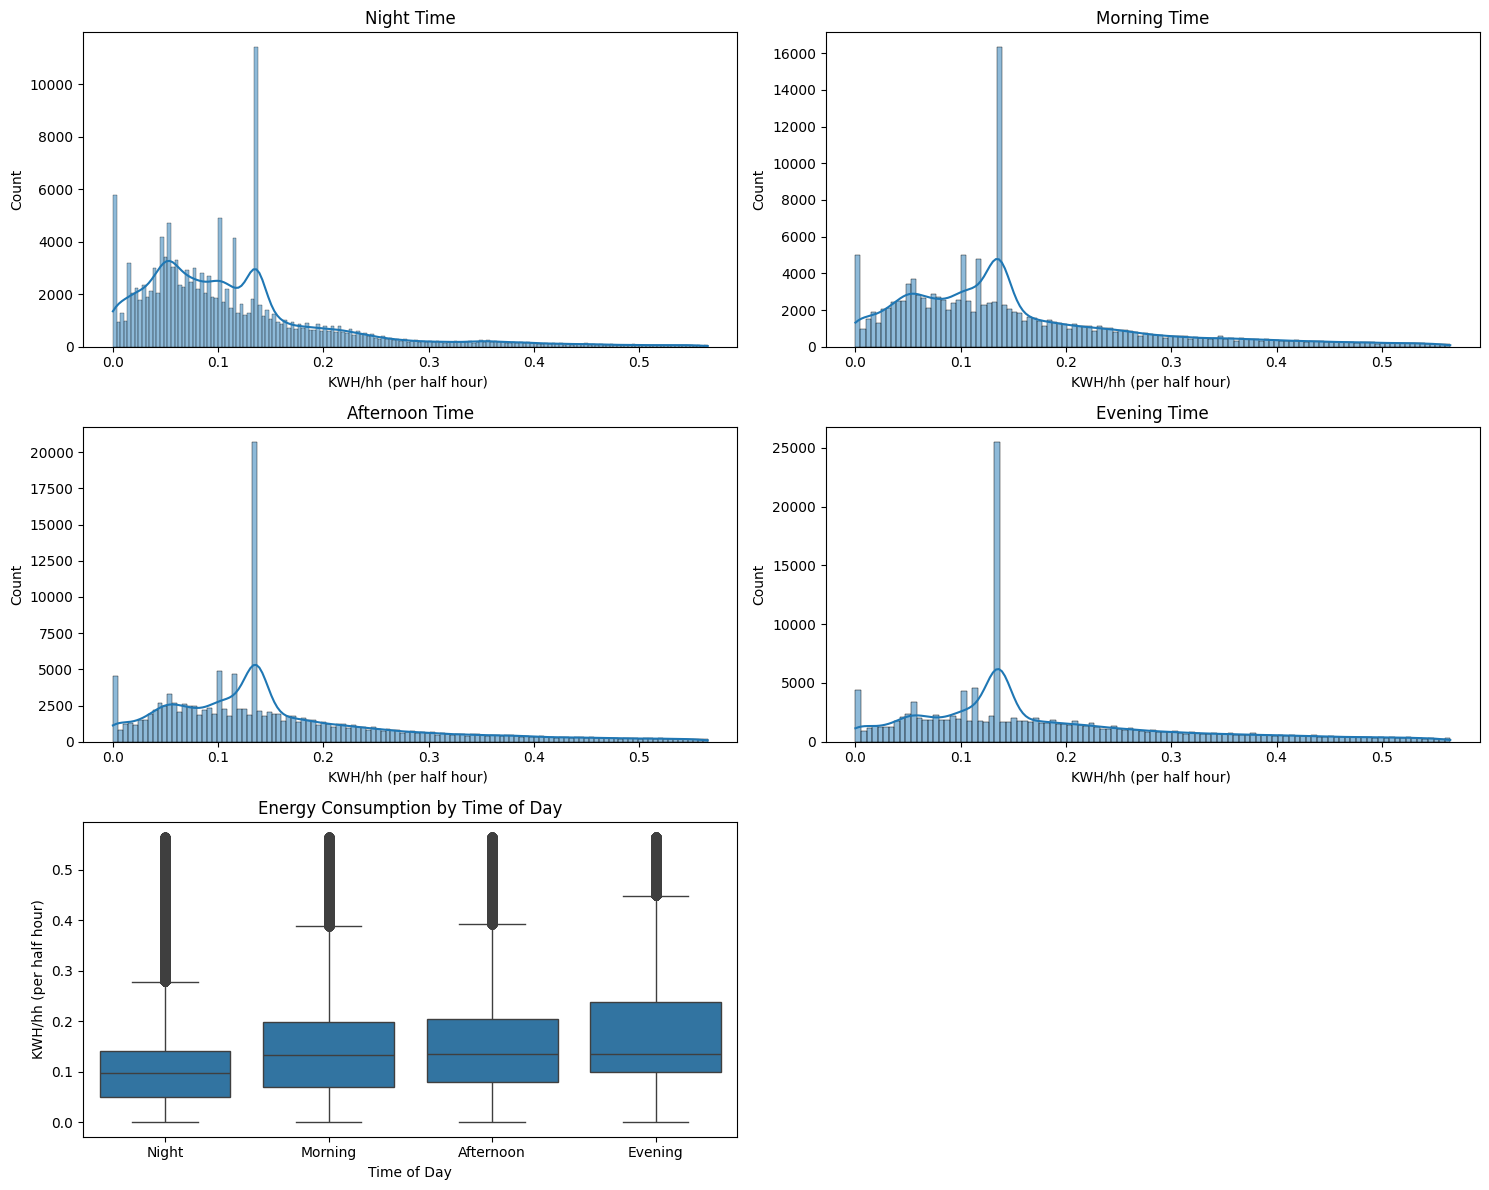

In [ ]:
def dayTimeVis(data):
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    sns.histplot(data=data[data['Time_of_Day'] == 'Night'], x='KWH/hh (per half hour) ', kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Night Time')

    sns.histplot(data=data[data['Time_of_Day'] == 'Morning'], x='KWH/hh (per half hour) ', kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Morning Time')

    sns.histplot(data=data[data['Time_of_Day'] == 'Afternoon'], x='KWH/hh (per half hour) ', kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Afternoon Time')

    sns.histplot(data=data[data['Time_of_Day'] == 'Evening'], x='KWH/hh (per half hour) ', kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Evening Time')

    sns.boxplot(x='Time_of_Day', y='KWH/hh (per half hour) ', data=data, ax=axes[2, 0])
    axes[2, 0].set_title('Energy Consumption by Time of Day')
    axes[2, 0].set_xlabel('Time of Day')
    axes[2, 0].set_ylabel('KWH/hh (per half hour)')

    fig.delaxes(axes[2, 1])

    plt.tight_layout()
    plt.show()

dayTimeVis(data)

# Threshold Recommendation and Cost Savings

#### Assuming that we can shutdown few cells were the consumption is low, what is the threshold that you would recommend and how much KW and EGP it would save accordingly?

First we can define what qualifies as "low consumption" based on the cells data of energy consumption

#### when I looked at what to be the low threshold there was extreme low values like 0 , .001 , .002 and it kept going like this so thought what we need is the lower amounts of energy usage compared to the majority of the other cells so that it represents "low-end" consumers that consistently low in usage for that I think Q1 25% is a reasonable boundary for non biased or extreme data points

In [ ]:
q1 = data['KWH/hh (per half hour) '].quantile(0.25)
q1

0.069

<ipython-input-72-5644dc42a693>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x='cell_id', y='KWH/hh (per half hour) ', palette='viridis')


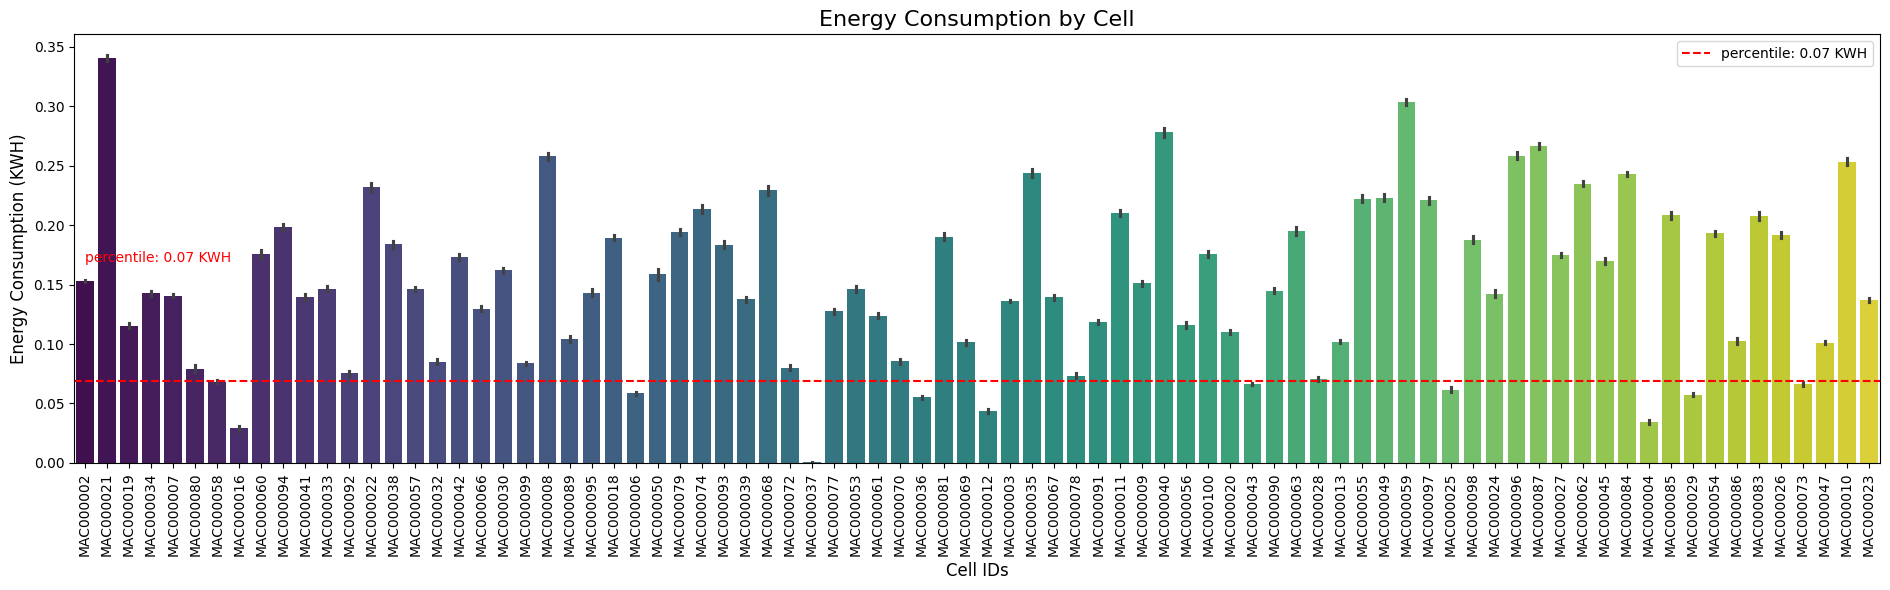

In [ ]:
plt.figure(figsize=(19, 6))
sns.barplot(data=merged_data, x='cell_id', y='KWH/hh (per half hour) ', palette='viridis')

plt.title('Energy Consumption by Cell', fontsize=16)
plt.xlabel('Cell IDs', fontsize=12)
plt.ylabel('Energy Consumption (KWH)', fontsize=12)
plt.xticks(rotation=90)

plt.axhline(y=q1, color='r', linestyle='--', label=f'percentile: {q1:.2f} KWH')

plt.text(0, q1 + 0.1, f'percentile: {q1:.2f} KWH', color='r')

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
threshold = q1
low_consumption_data = data[data['KWH/hh (per half hour) '] < threshold]

total_kw_saved = low_consumption_data['KWH/hh (per half hour) '].sum()
total_cost_saved = low_consumption_data['Cost(EGP)'].sum()

print(f"Threshold: {threshold} KW/hh")
print(f"Total KW saved: {total_kw_saved:.2f} KW")
print(f"Total EGP saved: {total_cost_saved:.2f} EGP")

Threshold: 0.069 KW/hh
Total KW saved: 5183.44 KW
Total EGP saved: 1049.48 EGP


A total of 5183.44 KWh could be saved by shutting down these low-consumption cells, This would result in 1049.48 EGP

In [ ]:
data

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Time,Date,Hour,Day,Week,Month,Time_of_Day,is_weekend,Demand,Cost(EGP)
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.042617
1,MAC000021,2013-01-01 00:00:00,0.372,E,A,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.072391
2,MAC000019,2013-01-01 00:00:00,0.195,K,B,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.037947
3,MAC000034,2013-01-01 00:00:00,0.136,E,A,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.026466
4,MAC000007,2013-01-01 00:00:00,0.247,H,C,00:00:00,2013-01-01,0,1,1,1,Night,0,Normal,0.048066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584230,MAC000083,2013-12-12 23:30:00,0.071,J,C,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low,0.004892
584231,MAC000068,2013-12-12 23:30:00,0.136,L,B,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low,0.009370
584232,MAC000027,2013-12-12 23:30:00,0.147,J,C,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low,0.010128
584233,MAC000003,2013-12-12 23:30:00,0.147,P,B,23:30:00,2013-12-12,23,12,50,12,Evening,0,Low,0.010128


In [ ]:
data.duplicated().sum()

0

In [ ]:
# data.drop(columns=['Cost_log'])

In [ ]:
# data.to_csv('data.csv', index=False)